In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.output_layer(x)
        return x

def adjusted_quantile_loss(outputs, targets, quantile, lower_bound=None, upper_bound=None):
    errors = targets - outputs
    basic_loss = torch.max((quantile - 1) * errors, quantile * errors)
    loss = torch.mean(basic_loss)

    if lower_bound is not None:
        crossing_penalty = torch.mean(torch.relu(lower_bound - outputs))
        loss += crossing_penalty
    if upper_bound is not None:
        crossing_penalty = torch.mean(torch.relu(outputs - upper_bound))
        loss += crossing_penalty

    return loss

# Load and prepare data

file_path = '//home/yui/Downloads/p122_synthetic_large.csv'
data = pd.read_csv(file_path)
# Randomly sample 10% of the dataset
#data = data.sample(frac=0.4, random_state=42)
#data = data.sample(frac=0.1, random_state=42)  # Smaller sample for speed
features = data[['battery_2#p122','gas-cc#p122','upv#p122','wind-ons#p122']]
target = data['value']
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize models and optimizers
quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05]
models = [NeuralNet(X_train.shape[1], 1) for _ in quantiles]
optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]

# Store bounds for each quantile and input
input_bounds = {q: {'lower': None, 'upper': None} for q in quantiles}

# Adjusted training loop
for epoch in range(100):
    for inputs, labels in train_loader:
        current_outputs = {}  # Dictionary to store outputs for current batch

        # Clear gradients at the start of each batch
        for optimizer in optimizers:
            optimizer.zero_grad()

        first_pass = True  # Flag to handle retain_graph properly

        for q_idx, quantile in enumerate(quantiles):
            model = models[q_idx]
            outputs = model(inputs)
            current_outputs[quantile] = outputs.detach().clone()  # Detach and clone to avoid in-place modifications

            # Assign bounds based on quantile relationships
            lower_bound = None
            upper_bound = None
            if quantile == 0.75:
                lower_bound = current_outputs.get(0.5)  # Lower bound from median
            elif quantile == 0.25:
                upper_bound = current_outputs.get(0.5)  # Upper bound from median
            elif quantile == 0.9:
                lower_bound = current_outputs.get(0.75)
            elif quantile == 0.1:
                upper_bound = current_outputs.get(0.25)
            elif quantile == 0.95:
                lower_bound = current_outputs.get(0.9)
            elif quantile == 0.05:
                upper_bound = current_outputs.get(0.1)

            # Adjusted quantile loss calculation
            loss = adjusted_quantile_loss(outputs, labels, quantile, lower_bound, upper_bound)
            loss.backward(retain_graph=first_pass)  # Only retain graph on the first backward pass

            first_pass = False  # Ensure subsequent passes do not retain graph
            # Print intermediate results after each epoch or more frequently if needed
            # if epoch % 10 == 0:  # Adjust the frequency of logging as needed
            #     print(f"Epoch {epoch + 1}, Quantile {quantile}, Loss: {loss.item()}")
            #     if lower_bound is not None and upper_bound is not None:
            #         print(f"Bounds for Quantile {quantile}: Lower Bound - {lower_bound.mean().item()}, Upper Bound - {upper_bound.mean().item()}")
            #     elif lower_bound is not None:
            #         print(f"Lower Bound for Quantile {quantile}: {lower_bound.mean().item()}")
            #     elif upper_bound is not None:
            #         print(f"Upper Bound for Quantile {quantile}: {upper_bound.mean().item()}")

        # Step each optimizer after all gradients have been computed for the batch
        for optimizer in optimizers:
            optimizer.step()

        # Optionally, clear dictionary to free memory after processing each batch
        current_outputs.clear()




# Evaluation of models
for i, model in enumerate(models):
    model.eval()
    with torch.no_grad():
        predictions_train = model(X_train)
        predictions_test = model(X_test)
        r2_train = r2_score(y_train.numpy(), predictions_train.numpy())
        r2_test = r2_score(y_test.numpy(), predictions_test.numpy())
        print(f'Quantile: {quantiles[i]}, Training R-squared: {r2_train:.4f}, Testing R-squared: {r2_test:.4f}')

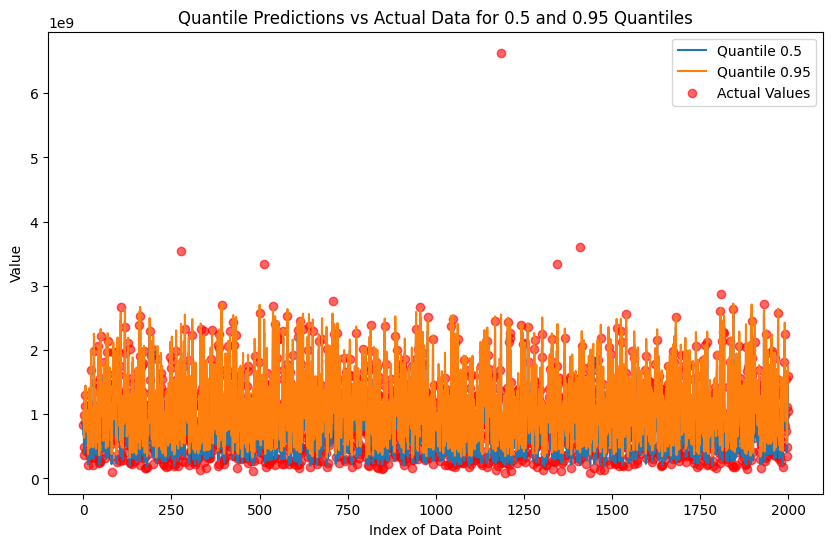

In [6]:
import matplotlib.pyplot as plt

# Assuming all previous code is correctly set up and models are trained
fig, ax = plt.subplots(figsize=(10, 6))

# Selectively generate predictions for quantile 0.5 and 0.95
selected_quantiles = [0.5, 0.95]  # Define the quantiles of interest
quantile_indices = [i for i, q in enumerate(quantiles) if q in selected_quantiles]  # Find indices of these quantiles

for i in quantile_indices:
    model = models[i]
    quantile = quantiles[i]
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()  # Obtain predictions for the test set
        ax.plot(predictions, label=f'Quantile {quantile}')  # Plot each selected quantile prediction

# Plot actual data points
actual_values = y_test.numpy()
ax.scatter(range(len(actual_values)), actual_values, color='red', label='Actual Values', alpha=0.6)

# Set plot title and labels
ax.set_title('Quantile Predictions vs Actual Data for 0.5 and 0.95 Quantiles')
ax.set_xlabel('Index of Data Point')
ax.set_ylabel('Value')

# Enable legend
ax.legend()

# Show plot
plt.show()

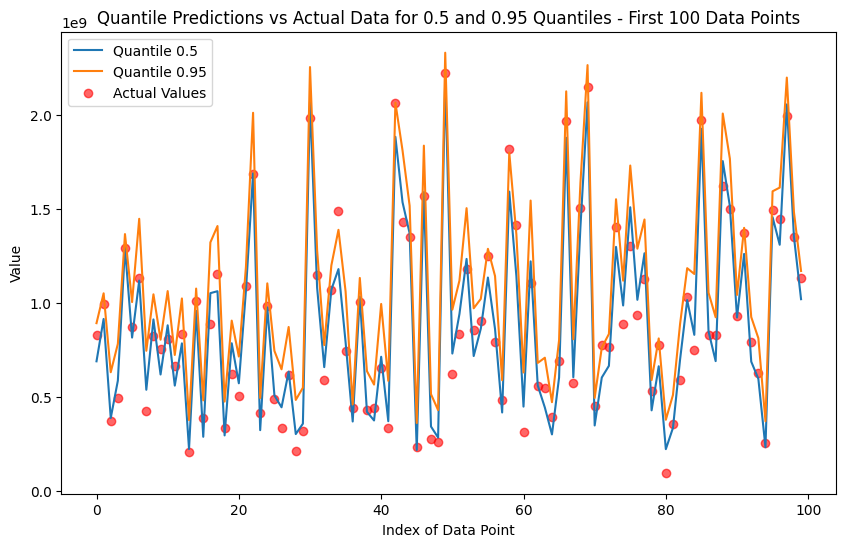

In [7]:
import matplotlib.pyplot as plt

# Assuming all previous code is correctly set up and models are trained
fig, ax = plt.subplots(figsize=(10, 6))

# Selectively generate predictions for quantile 0.5 and 0.95
selected_quantiles = [0.5, 0.95]  # Define the quantiles of interest
quantile_indices = [i for i, q in enumerate(quantiles) if q in selected_quantiles]  # Find indices of these quantiles

# Limit the number of data points to the first 100
limit = 100

for i in quantile_indices:
    model = models[i]
    quantile = quantiles[i]
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()[:limit]  # Obtain predictions for the test set and slice to first 100
        ax.plot(predictions, label=f'Quantile {quantile}')  # Plot each selected quantile prediction

# Plot actual data points for the first 100 only
actual_values = y_test.numpy()[:limit]
ax.scatter(range(len(actual_values)), actual_values, color='red', label='Actual Values', alpha=0.6)

# Set plot title and labels
ax.set_title('Quantile Predictions vs Actual Data for 0.5 and 0.95 Quantiles - First 100 Data Points')
ax.set_xlabel('Index of Data Point')
ax.set_ylabel('Value')

# Enable legend
ax.legend()

# Show plot
plt.show()

In [8]:
import os
!pip install joblib
import joblib

# Define directory path
dir_path = '/home/yui/Downloads/QNN-test'
os.makedirs(dir_path, exist_ok=True)

# Save models
for i, model in enumerate(models):
    torch.save(model.state_dict(), os.path.join(dir_path, f'model_{quantiles[i]}.pt'))

# Save scaler
joblib.dump(scaler, os.path.join(dir_path, 'scaler.pkl'))


Defaulting to user installation because normal site-packages is not writeable


['/home/yui/Downloads/QNN-test/scaler.pkl']

In [11]:
import torch
import joblib

# Ensure NeuralNet is defined in the scope or imported if defined externally
# from your_model_definition_file import NeuralNet  # Uncomment and modify if NeuralNet is in a different file

# Define quantiles and prepare model loading
quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05]
models = []
dir_path = '/home/yui/Downloads/QNN-test'

for quantile in quantiles:
    model = NeuralNet(input_size=4, output_size=1)  # Assuming input size is 4
    model_path = os.path.join(dir_path, f'model_{quantile}.pt')
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set model to evaluation mode
    models.append(model)

# Load scaler
scaler_path = os.path.join(dir_path, 'scaler.pkl')
scaler = joblib.load(scaler_path)

